# Analisis Exploratio de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

df_events = pd.read_csv("events.csv")
df_order_items = pd.read_csv("order_items.csv")
df_orders = pd.read_csv("orders.csv")
df_products = pd.read_csv("products.csv")
df_reviews = pd.read_csv("reviews.csv")
df_users = pd.read_csv("users.csv")


In [2]:
df_events.head()

,event_id,user_id,product_id,event_type,event_timestamp
0,E00000001,U009798,P001393,cart,2025-07-08T14:28:55.893919
1,E00000002,U005881,P000669,view,2025-10-19T23:00:44.067982
2,E00000003,U006348,P001404,view,2025-05-09T07:02:42.256662
3,E00000004,U002664,P000400,cart,2025-07-19T22:47:07.019634
4,E00000005,U005776,P000392,view,2024-10-24T10:20:33.602165


In [3]:
df_order_items.head()

,order_item_id,order_id,product_id,user_id,quantity,item_price,total_price
0,I00000001,O00000001,P001758,U009310,2,1650,3300
1,I00000002,O00000001,P001119,U009310,1,1550,1550
2,I00000003,O00000001,P001794,U009310,1,1750,1750
3,I00000004,O00000001,P001038,U009310,1,4350,4350
4,I00000005,O00000002,P000859,U003247,1,1400,1400


In [4]:
df_orders.head()

,order_id,user_id,order_date,order_status,total_amount
0,O00000001,U009310,9/09/2025 14:52,processing,10950
1,O00000002,U003247,15/04/2025 1:18,completed,11230
2,O00000003,U007252,27/04/2025 15:37,processing,39594
3,O00000004,U008986,4/10/2025 20:35,cancelled,22250
4,O00000005,U008537,13/11/2024 8:15,cancelled,14490


In [26]:
# Se cambia el nombre a una columna para evitar conflictos con la tabla df_reviews
df_products = df_products.rename(columns={"rating": "rating_product"})
df_products.drop(columns='Unnamed: 0',inplace=True)
df_products

,product_id,rating_product,ProductName,Brand,Price,Image_Url,Category,SubCategory
0,P000001,4.08,Onion (Loose),Fresho,69.75,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
1,P000002,3.87,Onion,Fresho,174.35,https://www.bigbasket.com/media/uploads/p/l/12...,Fruits & Vegetables,"Potato, Onion & Tomato"
2,P000003,3.46,"Farm Eggs - Table Tray, Medium, Antibiotic Res...",Fresho,110.00,https://www.bigbasket.com/media/uploads/p/l/40...,"Eggs, Meat & Fish",Farm Eggs
3,P000004,4.14,Potato (Loose),Fresho,50.32,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
4,P000005,3.97,Potato,Fresho,100.65,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
...,...,...,...,...,...,...,...,...
1995,P001996,4.28,Bio Wheat Germ Sleep Cream - BXL Cellular,BIOTIQUE,999.00,https://www.bigbasket.com/media/uploads/p/l/40...,Beauty & Hygiene,Face Care
1996,P001997,2.66,"Sunscreen Gel - Aloe Vera, SPF 20, Oily & Acne...",Aroma Magic,180.00,https://www.bigbasket.com/media/uploads/p/l/40...,Beauty & Hygiene,Face Care
1997,P001998,4.73,Sunscreen Gel - Aloe Vera,Aroma Magic,650.00,https://www.bigbasket.com/media/uploads/p/l/12...,Beauty & Hygiene,Face Care
1998,P001999,2.75,"Tilapia Fish - Whole Cut, Cleaned, Flavourful,...",Fresho,109.00,https://www.bigbasket.com/media/uploads/p/l/40...,"Eggs, Meat & Fish",Fresh Water Fish


In [6]:
df_reviews.head()

,review_id,order_id,product_id,user_id,rating,review_text,review_date
0,R00000528,O00000237,P001326,U001094,2,Color was different from images.,2025-10-14T12:03:56.749446
1,R00005792,O00002627,P000329,U001858,4,Highly recommend this brand.,2024-10-09T08:04:50.171793
2,R00036604,O00016798,P001160,U008109,4,Highly recommend this brand.,2024-06-03T05:11:16.787214
3,R00040163,O00018414,P001427,U006835,5,Highly recommend this brand.,2024-02-12T06:41:50.215810
4,R00031127,O00014300,P001639,U007148,3,Item arrived damaged.,2025-01-20T05:32:09.398860


In [7]:
df_users.head()

,user_id,name,email,gender,city,signup_date
0,U000001,Angel Hill,donaldgarcia@example.net,Other,New Roberttown,2025-03-13
1,U000002,Jesse Guzman,jennifermiles@example.com,Male,South Bridget,2024-03-05
2,U000003,Adam Shaffer,jpeterson@example.org,Male,Curtisfurt,2025-07-07
3,U000004,Melanie Munoz,blairamanda@example.com,Other,New Kellystad,2024-03-07
4,U000005,Janet Williams,kendragalloway@example.org,Female,South Joshuastad,2025-01-29


## Visualizacion de columnas y forma de las tablas

In [8]:
dataframes = {
    "events": df_events,
    "order_items": df_order_items,
    "orders": df_orders,
    "products": df_products,
    "reviews": df_reviews,
    "users": df_users,
}

for name, df in dataframes.items():
    print(f"\n=== {name.upper()} ===")
    print("Shape:", df.shape)
    print("Columnas:", list(df.columns))


=== EVENTS ===
Shape: (80000, 5)
Columnas: ['event_id', 'user_id', 'product_id', 'event_type', 'event_timestamp']

=== ORDER_ITEMS ===
Shape: (43525, 7)
Columnas: ['order_item_id', 'order_id', 'product_id', 'user_id', 'quantity', 'item_price', 'total_price']

=== ORDERS ===
Shape: (20000, 5)
Columnas: ['order_id', 'user_id', 'order_date', 'order_status', 'total_amount']

=== PRODUCTS ===
Shape: (2000, 9)
Columnas: ['Unnamed: 0', 'product_id', 'rating_product', 'ProductName', 'Brand', 'Price', 'Image_Url', 'Category', 'SubCategory']

=== REVIEWS ===
Shape: (15000, 7)
Columnas: ['review_id', 'order_id', 'product_id', 'user_id', 'rating', 'review_text', 'review_date']

=== USERS ===
Shape: (10000, 6)
Columnas: ['user_id', 'name', 'email', 'gender', 'city', 'signup_date']


## Tipo de variables en las tablas

In [9]:
for name, df in dataframes.items():
    print(f"\n=== {name.upper()} dtypes ===")
    print(df.dtypes)


=== EVENTS dtypes ===
event_id           object
user_id            object
product_id         object
event_type         object
event_timestamp    object
dtype: object

=== ORDER_ITEMS dtypes ===
order_item_id    object
order_id         object
product_id       object
user_id          object
quantity          int64
item_price        int64
total_price       int64
dtype: object

=== ORDERS dtypes ===
order_id        object
user_id         object
order_date      object
order_status    object
total_amount     int64
dtype: object

=== PRODUCTS dtypes ===
Unnamed: 0          int64
product_id         object
rating_product    float64
ProductName        object
Brand              object
Price             float64
Image_Url          object
Category           object
SubCategory        object
dtype: object

=== REVIEWS dtypes ===
review_id      object
order_id       object
product_id     object
user_id        object
rating          int64
review_text    object
review_date    object
dtype: object

=== U

## Verificacion de datos vacios entre tablas

In [10]:
for name, df in dataframes.items():
    print(f"\n=== {name.upper()} missing values ===")
    print(df.isna().sum())


=== EVENTS missing values ===
event_id           0
user_id            0
product_id         0
event_type         0
event_timestamp    0
dtype: int64

=== ORDER_ITEMS missing values ===
order_item_id    0
order_id         0
product_id       0
user_id          0
quantity         0
item_price       0
total_price      0
dtype: int64

=== ORDERS missing values ===
order_id        0
user_id         0
order_date      0
order_status    0
total_amount    0
dtype: int64

=== PRODUCTS missing values ===
Unnamed: 0        0
product_id        0
rating_product    0
ProductName       0
Brand             0
Price             0
Image_Url         0
Category          0
SubCategory       0
dtype: int64

=== REVIEWS missing values ===
review_id      0
order_id       0
product_id     0
user_id        0
rating         0
review_text    0
review_date    0
dtype: int64

=== USERS missing values ===
user_id        0
name           0
email          0
gender         0
city           0
signup_date    0
dtype: int64


In [11]:
for nombre, df in dataframes.items():
    print(f"=== Resumen: {nombre} ===")
    print(df.describe())
    print("\n" + "="*40 + "\n")

=== Resumen: events ===
         event_id  user_id product_id event_type             event_timestamp
count       80000    80000      80000      80000                       80000
unique      80000     9995       2000          4                       80000
top     E00000001  U006046    P001112       view  2025-07-08T14:28:55.893919
freq            1       23         63      56013                           1


=== Resumen: order_items ===
           quantity    item_price    total_price
count  43525.000000  43525.000000   43525.000000
mean       1.397312   4430.204825    6191.956117
std        0.660717   4826.565477    7989.931436
min        1.000000     50.000000      50.000000
25%        1.000000   1490.000000    1800.000000
50%        1.000000   2850.000000    3720.000000
75%        2.000000   5600.000000    7450.000000
max        3.000000  60000.000000  180000.000000


=== Resumen: orders ===
        total_amount
count   20000.000000
mean    13475.244500
std     14140.478064
min      

## Cambio de tipo de variable a fecha de columnas con esta caracteristica

In [12]:
date_cols = {
    "events": ["event_timestamp"],
    "orders": ["order_date"],
    "reviews": ["review_date"],
    "users": ["signup_date"],
}

for name, cols in date_cols.items():
    df = dataframes[name]
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], dayfirst=True, format='mixed')

print(df_events.dtypes)

event_id                   object
user_id                    object
product_id                 object
event_type                 object
event_timestamp    datetime64[ns]
dtype: object


## Analisis de la tabla "Users"

In [13]:
print("Distribucion de generos")
df_users["gender"].value_counts()

Distribucion de generos


gender
Other     3419
Female    3334
Male      3247
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


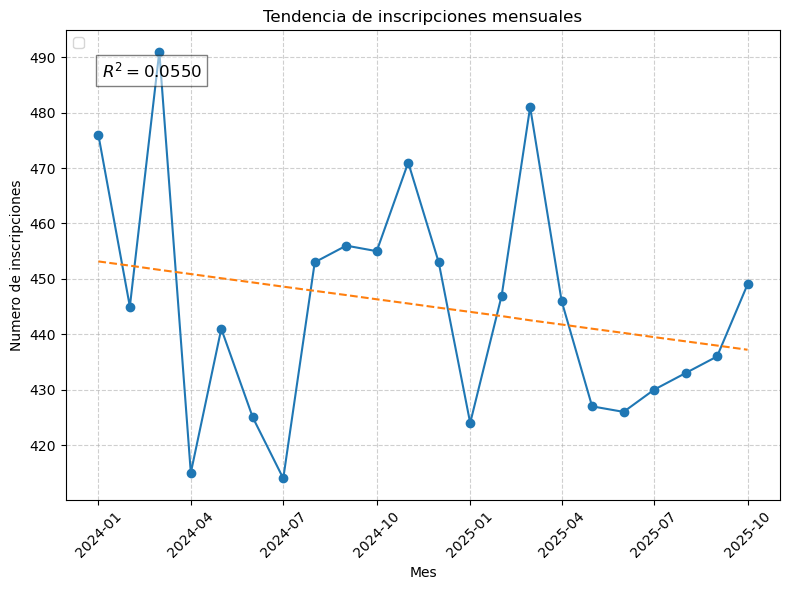

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

df_users["signup_date"] = pd.to_datetime(df_users["signup_date"])

signup_MOM = df_users["signup_date"].dt.to_period("M").value_counts().sort_index()
signup_MOM = signup_MOM[signup_MOM.index < "2025-11-01"]

signup_MOM_indice = signup_MOM.index.to_timestamp()

x_vals = np.arange(len(signup_MOM))
y_vals = signup_MOM.values

z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
y_pred = p(x_vals)
r2 = r2_score(y_vals, y_pred)

plt.figure(figsize=(8, 6))
ax = plt.gca()

ax.plot(signup_MOM_indice, y_vals, marker="o")
ax.plot(signup_MOM_indice, y_pred, linestyle="--")

ax.text(0.05, 0.9, f'$R^2 = {r2:.4f}$', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title("Tendencia de inscripciones mensuales")
plt.xlabel("Mes")
plt.ylabel("Numero de inscripciones")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

*Viendo el R2 podemos decir, no con mucha fidelidad (R2 0.055) por el tipo de datos, que a través del tiempo los signups tenderán a disminuir con el tiempo.*

## Analisis de eventos

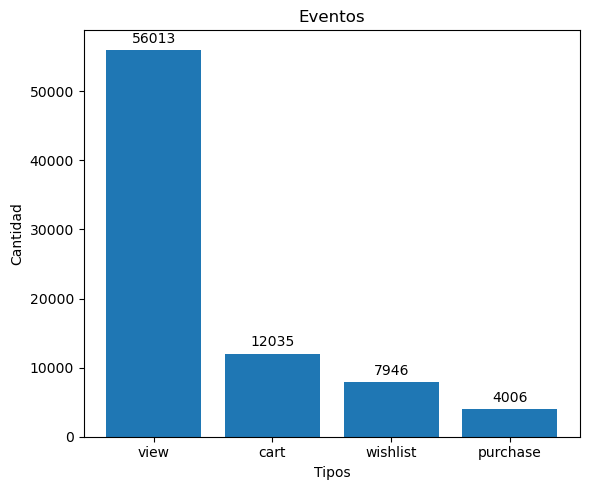

In [15]:
event_counts = df_events["event_type"].value_counts()

plt.figure(figsize=(6,5))
bars = plt.bar(event_counts.index.astype(str), event_counts.values)
plt.title("Eventos")
plt.xlabel("Tipos")
plt.ylabel("Cantidad")
plt.bar_label(bars, padding=3)
plt.tight_layout()
plt.show()

In [16]:
# Union de tablas de events y productos para mejor analisis
df_events_products = df_events.merge(df_products, how="left")

In [17]:
# Se crea una vista para las 2 categorias de productos mas vistas
df_views = df_events_products[df_events_products['event_type'] == 'view']
categoria_mas_vista = df_views.groupby('Category').size().sort_values(ascending=False)
print("Las categorias mas vistas son:")
print(categoria_mas_vista.head(3),"\n")
print("---"*10)
# Se crea una vista para las 2 categorias de productos mas compradas
df_purchase = df_events_products[df_events_products['event_type'] == 'purchase']
categoria_mas_comprada = df_purchase.groupby('Category').size().sort_values(ascending=False)
print("\nLas categorias mas compradas son:")
print(categoria_mas_comprada.head(3))

Las categorias mas vistas son:
Category
Beauty & Hygiene            23605
Foodgrains, Oil & Masala     8124
Eggs, Meat & Fish            5694
dtype: int64 

------------------------------

Las categorias mas compradas son:
Category
Beauty & Hygiene            1681
Foodgrains, Oil & Masala     587
Eggs, Meat & Fish            407
dtype: int64


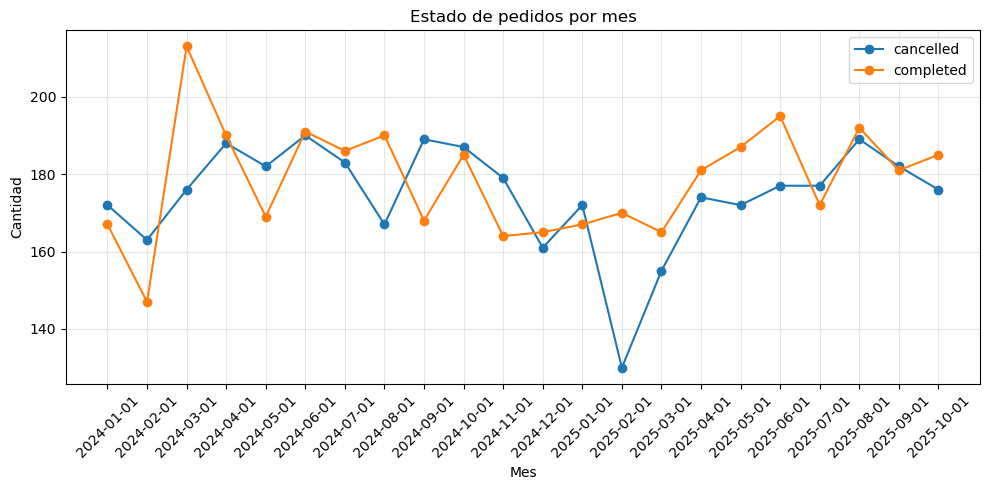

In [18]:
estados = ['completed', 'cancelled']
df_filtrado = df_orders[df_orders['order_status'].isin(estados)].copy()
df_filtrado['order_date'] = pd.to_datetime(df_filtrado['order_date'])
df_monthly = df_filtrado.groupby([df_filtrado['order_date'].dt.to_period('M'), 'order_status']).size().unstack(fill_value=0)
df_monthly = df_monthly[df_monthly.index < "2025-11-01"]
df_monthly.index = df_monthly.index.to_timestamp()

plt.figure(figsize=(10, 5))
df_monthly.index = df_monthly.index.astype(str)
for status in df_monthly.columns:
    plt.plot(df_monthly.index, df_monthly[status], marker='o', label=status)
plt.title(f"Estado de pedidos por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Se comparan 2 estados de pedidos, se puede ver que hay meses donde los pedidos tienen mayor numero de estados cancelados que completados, lo cual puede significar perdidas de ganancias en la compañia, se sugiere una revision operacional en el tema de envios de los productos y mejorar los tiempos de entrega*

## Analisis de ganancias

In [19]:
df_order_items

,order_item_id,order_id,product_id,user_id,quantity,item_price,total_price
0,I00000001,O00000001,P001758,U009310,2,1650,3300
1,I00000002,O00000001,P001119,U009310,1,1550,1550
2,I00000003,O00000001,P001794,U009310,1,1750,1750
3,I00000004,O00000001,P001038,U009310,1,4350,4350
4,I00000005,O00000002,P000859,U003247,1,1400,1400
...,...,...,...,...,...,...,...
43520,I00043521,O00019999,P001684,U006170,1,2500,2500
43521,I00043522,O00020000,P001940,U009938,3,3990,11970
43522,I00043523,O00020000,P000221,U009938,3,100,300
43523,I00043524,O00020000,P000248,U009938,1,700,700


In [20]:
df_orders_products = df_order_items.merge(df_products,how="left")

In [21]:
# Se unen las tablas de order_items y productos para mejor analisis
df_orders_products = df_order_items.merge(df_products,how="left")
revenue =  df_orders_products["total_price"].sum()
average_per_order = df_orders["total_amount"].mean()
print(f"El revenue total es de: ${round(revenue,2)}\n")
print(f"El valor promedio por orden es de: ${round(average_per_order,2)}")

El revenue total es de: $269504890

El valor promedio por orden es de: $13475.24


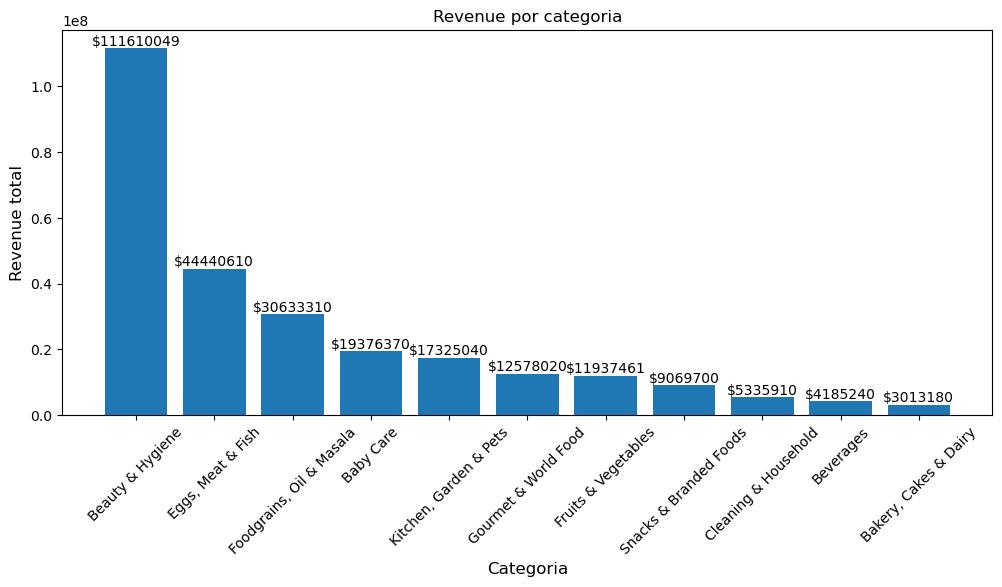

In [22]:
df_revenue_category = df_orders_products.groupby("Category")["total_price"].sum().sort_values(ascending=False)


plt.figure(figsize=(12, 5))
bars = plt.bar(df_revenue_category.index, df_revenue_category.values)
plt.bar_label(bars, fmt='$%.0f')
plt.title("Revenue por categoria")
plt.xlabel("Categoria", fontsize=12)
plt.ylabel("Revenue total", fontsize=12)
plt.xticks(rotation=45)
plt.show()


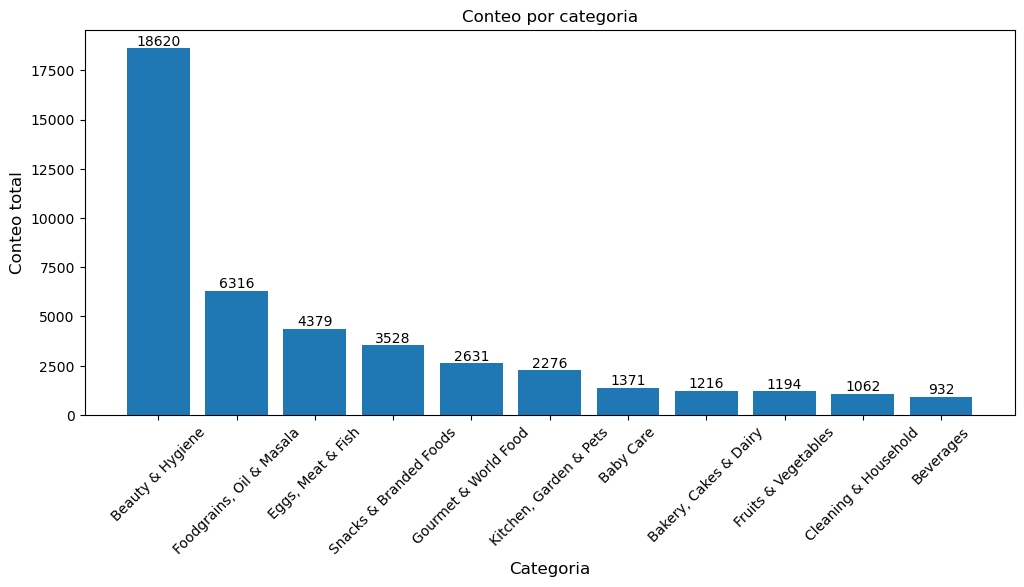

In [36]:
df_count_category = df_orders_products.groupby("Category")['product_id'].count().sort_values(ascending=False)


plt.figure(figsize=(12, 5))
bars = plt.bar(df_count_category.index, df_count_category.values)
plt.bar_label(bars, fmt='%.0f')
plt.title("Conteo por categoria")
plt.xlabel("Categoria", fontsize=12)
plt.ylabel("Conteo total", fontsize=12)
plt.xticks(rotation=45)
plt.show()

## Analisis de rating

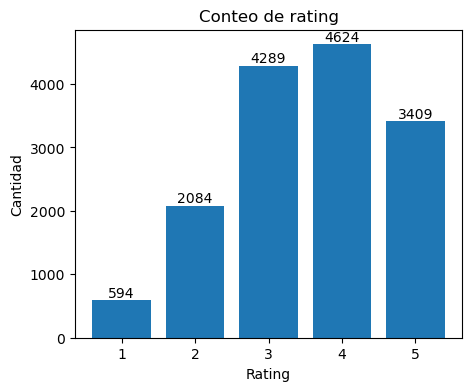

In [23]:
plt.figure(figsize=(5, 4))
bars = plt.bar(df_reviews["rating"].value_counts().index, df_reviews["rating"].value_counts().values)
plt.bar_label(bars)
plt.title("Conteo de rating")
plt.xlabel("Rating")
plt.ylabel("Cantidad")
plt.show()

## Ratings negativos por mes con linea de coefeciente de determinacion

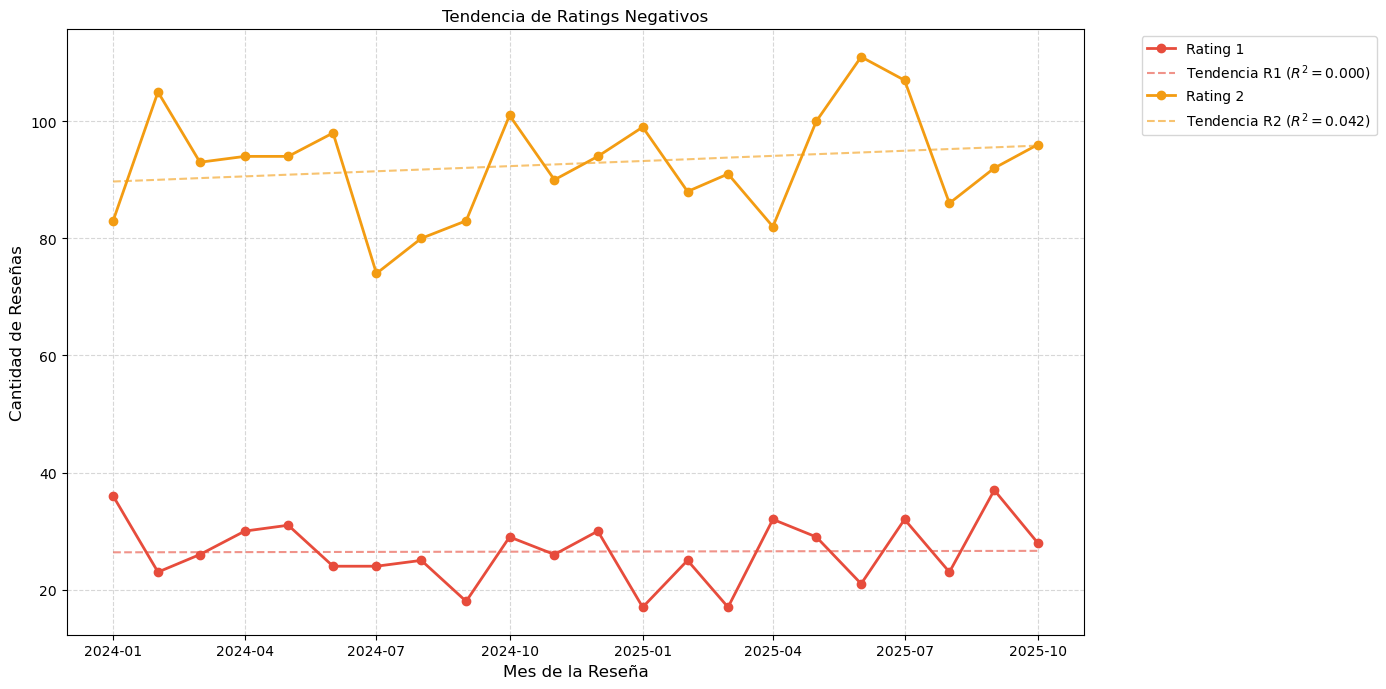

In [24]:
ratings = [1, 2]
df_ratings_negativos = df_reviews[df_reviews["rating"].isin(ratings)].copy()
df_ratings_negativos["review_date"] = pd.to_datetime(df_ratings_negativos["review_date"])

df_ratings_negativos = df_ratings_negativos[df_ratings_negativos["review_date"] < "2025-11-01"]

df_monthly_neg_ratings = df_ratings_negativos.groupby([
    df_ratings_negativos["review_date"].dt.to_period("M"), 
    "rating"
]).size().unstack(fill_value=0)

df_monthly_neg_ratings.index = df_monthly_neg_ratings.index.to_timestamp()

plt.figure(figsize=(14, 7))
ax = plt.gca()
colors = {1: '#e74c3c', 2: '#f39c12'}
x_vals = np.arange(len(df_monthly_neg_ratings))

for rating in ratings:
    y_vals = df_monthly_neg_ratings[rating].values
    ax.plot(df_monthly_neg_ratings.index, y_vals, marker='o', label=f'Rating {rating}', color=colors[rating], linewidth=2)
    
    z = np.polyfit(x_vals, y_vals, 1)
    p = np.poly1d(z)
    y_pred = p(x_vals)
    r2 = r2_score(y_vals, y_pred)
    
    ax.plot(df_monthly_neg_ratings.index, y_pred, linestyle='--', color=colors[rating], alpha=0.6, 
            label=f'Tendencia R{rating} ($R^2 = {r2:.3f}$)')

plt.title('Tendencia de Ratings Negativos')
plt.xlabel('Mes de la Reseña', fontsize=12)
plt.ylabel('Cantidad de Reseñas', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

*Los ratings nivel 1 no siguen un patrón y son aleatorios. Sin embargo, los ratings nivel 2 muestran una tendencia al alza, lo que indica que el descontento leve de los clientes está creciendo poco a poco*

In [53]:
df_reviews_productos = df_reviews.merge(df_products, how="left")
df_negativos = df_reviews_productos[df_reviews_productos["rating"].isin([1, 2])]
reporte_negativo = (df_negativos.groupby(["rating", "Category"]).size().sort_values(ascending=False).groupby(level=0).head(2))

print("\nSe muestra el nivel 1 y 2 junto a sus 2 categorias mas afectadas\n")
print("--"*30)
print(reporte_negativo)


Se muestra el nivel 1 y 2 junto a sus 2 categorias mas afectadas

------------------------------------------------------------
rating  Category                
2       Beauty & Hygiene            883
        Foodgrains, Oil & Masala    301
1       Beauty & Hygiene            247
        Foodgrains, Oil & Masala     92
dtype: int64


---

---